In [7]:
import pandas as pd

# Data Loading

In [8]:
from api.data_handler import DataHandler

# Creation of a DataHandler Object
data_handler = DataHandler(['target', 'col1', 'col2', 'col3', 'col4', 'col5', 'col6', 'id'])

# Number of different Datasets
datasets_number = 3

# Lists of DataFrames
df_train : list[pd.DataFrame] = []
df_test  : list[pd.DataFrame] = []

# Load the Training/Test sets into pandas DataFrames
for i in range(datasets_number):
    df_train.append(data_handler.load_data(f'data/monks/monks-{i+1}.train'))
    df_test.append(data_handler.load_data(f'data/monks/monks-{i+1}.test'))

    # Print the head of the loaded data
    print(df_train[i].head())
    print(df_test[i].head())

     target  col1  col2  col3  col4  col5  col6       id
NaN       1     1     1     1     1     3     1   data_5
NaN       1     1     1     1     1     3     2   data_6
NaN       1     1     1     1     3     2     1  data_19
NaN       1     1     1     1     3     3     2  data_22
NaN       1     1     1     2     1     2     1  data_27
     target  col1  col2  col3  col4  col5  col6      id
NaN       1     1     1     1     1     1     1  data_1
NaN       1     1     1     1     1     1     2  data_2
NaN       1     1     1     1     1     2     1  data_3
NaN       1     1     1     1     1     2     2  data_4
NaN       1     1     1     1     1     3     1  data_5
     target  col1  col2  col3  col4  col5  col6       id
NaN       0     1     1     1     1     2     2   data_4
NaN       0     1     1     1     1     4     1   data_7
NaN       0     1     1     1     2     1     1   data_9
NaN       0     1     1     1     2     1     2  data_10
NaN       0     1     1     1     2  

# Data Split

In [9]:
# Lists of data
x_train : list[pd.DataFrame] = []
y_train : list[pd.DataFrame] = []
x_test  : list[pd.DataFrame] = []
y_test  : list[pd.DataFrame] = []

# Split data into TR set and TS set
for i in range(datasets_number):

    # Saving the splitted TR set data into the lists
    df_train[i] = df_train[i].drop(columns=['id'], axis=1).copy(deep=True)
    x, y = data_handler.split_data(data=df_train[i], cols_name_split=['target'])
    x_train.append(x)
    y_train.append(y)

    # Saving the splitted TS set data into the lists
    df_test[i] = df_test[i].drop(columns=['id'], axis=1).copy(deep=True)
    x, y = data_handler.split_data(data=df_test[i], cols_name_split=['target'])
    x_test.append(x)
    y_test.append(y)


# 1-Hot Encoding

In [10]:
# Applies the 1-Hot Encoding to the "x" data
for i in range(datasets_number):
    x_train[i] = data_handler.one_hot_encoding(x_train[i])
    x_test[i]  = data_handler.one_hot_encoding(x_test[i])

    # Print of the data modified
    print(f"Monk {i+1} [TRAIN]: " + str(x_train[i].shape))
    print(f"Monk {i+1} [TEST]: " + str(x_test[i].shape))

Monk 1 [TRAIN]: (124, 17)
Monk 1 [TEST]: (432, 17)
Monk 2 [TRAIN]: (169, 17)
Monk 2 [TEST]: (432, 17)
Monk 3 [TRAIN]: (122, 17)
Monk 3 [TEST]: (432, 17)


# Grid Search parameters

In [11]:
# Parameters' space for Grid Search (1 for each Dataset)
param_space = {
    0: {
        'hidden_units': [3, 4],
        'patience': [15, 30],
        'learning_rate': [0.4, 0.1],
        'batch_size': [4, 6],
        'nesterov': ["T", "F"],
        'epochs': [180, 250],
        'momentum': [0.6, 0.7]
    },
    1: {
        'hidden_units': [3, 4, 5],
        'patience': [15, 30],
        'factor_lr_dec': [0.5, 1],
        'step_decay': [500, 1000, 1500],
        'learning_rate': [0.9, 0.8, 0.7],
        'batch_size': [10, 30, 60], 
        'epochs': [180, 200],
        'momentum': [0.6, 0.7, 0.8],
        'nesterov': ["T", "F"],
    },
    
    2: {
        'hidden_units': [2, 3, 4],
        'patience': [10,15,30],
        'nesterov': ["T", "F"],
        'learning_rate': [float(i/10) for i in range(1,10)] + [float(i/100) for i in range(1,10)] + [float(i/1000) for i in range(1,10)],
        'batch_size': [7, 8, 9, 15, 16, 17, 31, 32, 33, 62, 63, 64, 65],
        'epochs': [int(350+epochs) for epochs in range(0,50,10)],
        'weight_decay': [float(i/1000) for i in range(1,10)] + [float(i/100) for i in range(1,10)] + [float(i/10) for i in range(1,10)],
        'momentum': [float(i/1000) for i in range(10,90,5)] + [float(i/100) for i in range(10,90,5)],
    }  


        
        
}

# Model Selection

## Best Hyperparameters Research

In [12]:
from sklearn.model_selection import StratifiedKFold
from api.binary_nn import BinaryNN

# Creation of a BinaryNN objct for each dataset
nn: list[BinaryNN] = []

# Different values per dataset
trials_list = [1, 1, 200]
k_values = [5, 5, 5]
n_hidden_layers_list = [1, 1, 1]

# Search of the best Hyperparameters to each Training set
for dataset_i in range(datasets_number):
    X = x_train[dataset_i].values
    y = y_train[dataset_i].values
    k = k_values[dataset_i]

    # K-fold Cross-validation
    kfold = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

    for i in range(trials_list[dataset_i]):

    # Computes and Stores all the parameters combinations
    #data_handler.set_params_combinations(params=param_space[dataset_i])
        params = data_handler.random_dictionary(params=param_space[dataset_i])

    #params_combinations = data_handler.get_params_combinations()

    # For each iteration we choose the hyperparameters and we use them with K-fold CV
    #for trial, params in enumerate(params_combinations):

        # Creation of the Neural Network object
        nn_i = BinaryNN(params=params, monk_i=dataset_i+1, trial=i+1)

         # Building the model
        nn_i.create_model(n_hidden_layers=n_hidden_layers_list[dataset_i])

        # For each K-fold returns the indexes of the data splitted in: <X_train,y_train> and <X_val,y_val>
        for train_index, val_index in kfold.split(X, y):
            x_kfold_train, x_kfold_val = X[train_index], X[val_index]
            y_kfold_train, y_kfold_val = y[train_index], y[val_index]


            # Training the model
            nn_i.fit(
                x_train=x_kfold_train,
                y_train=y_kfold_train,
                x_val=x_kfold_val,
                y_val=y_kfold_val
            )

            # Evaluating the model
            nn_i.evaluate(
                x_train=x_kfold_train,
                y_train=y_kfold_train,
                x_val=x_kfold_val,
                y_val=y_kfold_val
            )

        # Case of first append
        if len(nn) == dataset_i:
            nn.append(nn_i)

        # Print the results of this trial
        print("------------------ Current Hyperparameters ------------------")
        nn_i.print_training_info()
        print("-------------------- Best Hyperparameters -------------------")
        nn[dataset_i].print_training_info()
        print("\n\n")

        # Update best hyperparameters if: no high overfitting AND (higher mean VL accuracy OR (equal mean AND
        if nn_i.mean_tr_accuracy-0.1 <= nn_i.mean_vl_accuracy \
            and (
                    nn[dataset_i].mean_vl_accuracy < nn_i.mean_vl_accuracy \
                or (
                    nn[dataset_i].mean_vl_accuracy == nn_i.mean_vl_accuracy and nn[dataset_i].mean_tr_accuracy < nn_i.mean_tr_accuracy
                    )
            ):
            nn[dataset_i] = nn_i

        # Case of TR/VL AND TR/VL loss minor
        if nn_i.mean_tr_accuracy == 1 and nn_i.mean_vl_accuracy >= 0.98 \
            and nn_i.mean_tr_accuracy == nn[dataset_i].mean_tr_accuracy \
            and nn_i.mean_vl_accuracy == nn[dataset_i].mean_vl_accuracy \
            and abs(nn_i.mean_tr_accuracy - nn_i.mean_vl_accuracy) < 0.02 \
            and nn_i.mean_vl_loss < nn[dataset_i].mean_vl_loss \
            and nn_i.mean_tr_loss < nn[dataset_i].mean_tr_loss:
            nn[dataset_i] = nn_i

        # Exit case
        if nn_i.mean_tr_accuracy == 1 and nn_i.mean_vl_accuracy == 1 \
            and nn_i.mean_vl_loss < 0.1 and nn_i.mean_tr_loss < 0.1 \
            and abs(nn_i.mean_vl_loss - nn_i.mean_tr_loss) < 0.01:
            nn[dataset_i] = nn_i
            break

    # Print output
    print(f"### Best Hyperparameters of Monk {dataset_i+1} ###")
    nn[dataset_i].print_training_info()
    print("\n\n")

------------------ Current Hyperparameters ------------------
 Monk:                              1
 Trial:                             1
 Hyperparameters:                   {'hidden_units': 4, 'patience': 15, 'learning_rate': 0.1, 'batch_size': 6, 'nesterov': 'F', 'epochs': 180, 'momentum': 0.6}
 Mean Training Loss:                0.00041384465293958783
 Mean Validation Loss:              0.0006501618161564692
 Mean Training Accuracy:            1.0
 Mean Validation Accuracy:          1.0
 Standard Deviation VL Accuracy:    0.0
 Variance VL Accuracy:              0.0
 Standard Deviation VL Loss:        0.000740765443616073
 Variance VL Loss:                  5.487334424557174e-07

-------------------- Best Hyperparameters -------------------
 Monk:                              1
 Trial:                             1
 Hyperparameters:                   {'hidden_units': 4, 'patience': 15, 'learning_rate': 0.1, 'batch_size': 6, 'nesterov': 'F', 'epochs': 180, 'momentum': 0.6}
 Mean Train

KeyboardInterrupt: 

## Print of best Hyperparameters 


### Best Hyperparameters for Monk 1 ###
 Monk:                              1
 Trial:                             1
 Hyperparameters:                   {'hidden_units': 4, 'patience': 15, 'learning_rate': 0.1, 'batch_size': 6, 'nesterov': 'F', 'epochs': 180, 'momentum': 0.6}
 Mean Training Loss:                0.00041384465293958783
 Mean Validation Loss:              0.0006501618161564692
 Mean Training Accuracy:            1.0
 Mean Validation Accuracy:          1.0
 Standard Deviation VL Accuracy:    0.0
 Variance VL Accuracy:              0.0
 Standard Deviation VL Loss:        0.000740765443616073
 Variance VL Loss:                  5.487334424557174e-07


### Best Hyperparameters for Monk 2 ###
 Monk:                              2
 Trial:                             1
 Hyperparameters:                   {'hidden_units': 4, 'patience': 15, 'factor_lr_dec': 1.0, 'step_decay': 1500, 'learning_rate': 0.9, 'batch_size': 10, 'epochs': 200, 'momentum': 0.8, 'nesterov': 'F'}
 Mean Trai

"\nBest Hyperparameters for Monk 2\n Monk:                     2\n Trial:                    3\n Hyperparameters:          {'input_units': 17, 'hidden_units': 5, 'patience': 200, 'factor_lr_dec': 1.0, 'step_decay': 500, 'learning_rate': 0.999, 'batch_size': 60, 'epochs': 290, 'momentum': 0.75, 'nesterov': 'T', 'activation': 'tanh', 'output_activation': 'sigmoid', 'metrics': 'accuracy'}\n Mean Training Loss:       0.0006283932307269424\n Mean Validation Loss:     0.004200904699973762\n Mean Training Accuracy:   1.0\n Mean Validation Accuracy: 1.0\n\n### Best Hyperparameters for Monk 3 ###\n Monk:                     3\n Trial:                    14\n Hyperparameters:          {'input_units': 17, 'hidden_units': 2, 'patience': 30, 'factor_lr_dec': 1.0, 'step_decay': 1500, 'learning_rate': 0.07, 'batch_size': 7, 'epochs': 370, 'weight_decay': 0.002, 'momentum': 0.08, 'nesterov': 'T', 'activation': 'tanh', 'output_activation': 'sigmoid', 'metrics': 'accuracy'}\n Mean Training Loss:       0

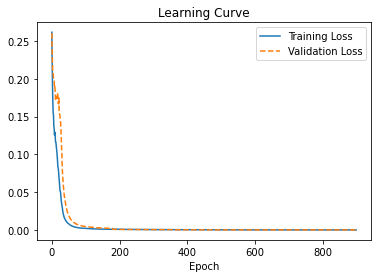

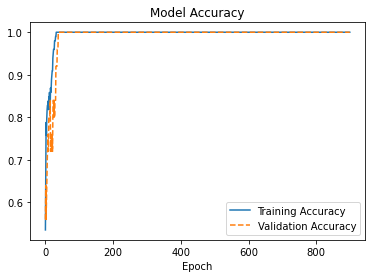

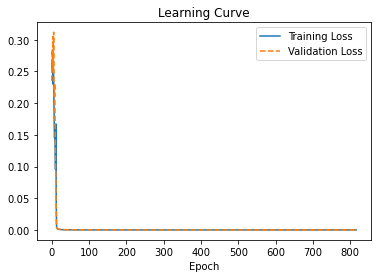

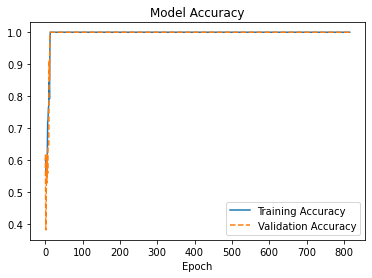

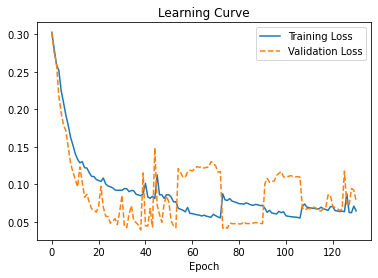

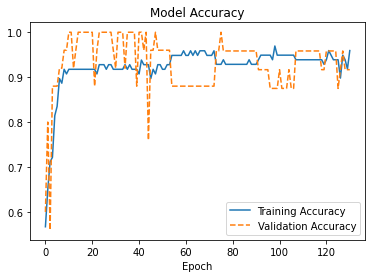

In [13]:
# Iteration on all the Datasets
for dataset_i in range(datasets_number):

    # Print best hyperparameters
    print(f"\n### Best Hyperparameters for Monk {dataset_i+1} ###")
    nn[dataset_i].print_training_info()
    nn[dataset_i].print_plot()
   
 
    # BEST L CURVE M1: >(semismoothed)
    # Hyperparameters:          {'input_units': 17, 'hidden_units': 5, 'patience': 100, 'factor_lr_dec': 0.5, 'step_decay': 1500, 'learning_rate': 0.999, 'batch_size': 17, 'epochs': 350, 'weight_init': 'glorot_normal', 'momentum': 0.4, 'activation': 'tanh', 'output_activation': 'sigmoid', 'metrics': 'accuracy'}
    #  Hyperparameters:          {'input_units': 17, 'hidden_units': 5, 'patience': 100, 'factor_lr_dec': 0.5, 'step_decay': 1000, 'learning_rate': 0.5, 'batch_size': 32, 'epochs': 370, 'weight_init': 'lecun_normal', 'momentum': 0.8, 'activation': 'tanh', 'output_activation': 'sigmoid', 'metrics': 'accuracy'}
    # Hyp:  {'input_units': 17, 'hidden_units': 5, 'patience': 200, 'factor_lr_dec': 0.5, 'step_decay': 500, 'learning_rate': 0.99, 'batch_size': 16, 'epochs': 530, 'weight_init': 'lecun_normal', 'momentum': 0.5, 'activation': 'tanh', 'output_activation': 'sigmoid', 'metrics': 'accuracy'}
    
    # BEST SMOOTHED CURVE MONK1:   HyperparameterS: {'hidden_units': 4, 'patience': 30, 'learning_rate': 0.3, 'batch_size': 4, 'nesterov': 'T', 'epochs': 440, 'momentum': 0.6}
                                                     #Hyperparameters:          {'input_units': 17, 'hidden_units': 4, 'patience': 15, 'learning_rate': 0.3, 'batch_size': 4, 'nesterov': 'F', 'epochs': 440, 'momentum': 0.7, 'activation': 'tanh', 'output_activation': 'sigmoid', 'metrics': 'accuracy'}

   # BEST SMOOTHER PT2 MONK2:  {'hidden_units': 4, 'patience': 10, 'learning_rate': 0.4, 'batch_size': 6, 'nesterov': 'T', 'epochs': 450, 'momentum': 0.3, 'activation': 'tanh', 'output_activation': 'sigmoid', 'metrics': 'accuracy'}

'''
Best Hyperparameters for Monk 2
 Monk:                     2
 Trial:                    3
 Hyperparameters:          {'input_units': 17, 'hidden_units': 5, 'patience': 200, 'factor_lr_dec': 1.0, 'step_decay': 500, 'learning_rate': 0.999, 'batch_size': 60, 'epochs': 290, 'momentum': 0.75, 'nesterov': 'T', 'activation': 'tanh', 'output_activation': 'sigmoid', 'metrics': 'accuracy'}
 Mean Training Loss:       0.0006283932307269424
 Mean Validation Loss:     0.004200904699973762
 Mean Training Accuracy:   1.0
 Mean Validation Accuracy: 1.0

### Best Hyperparameters for Monk 3 ###
 Monk:                     3
 Trial:                    14
 Hyperparameters:          {'input_units': 17, 'hidden_units': 2, 'patience': 30, 'factor_lr_dec': 1.0, 'step_decay': 1500, 'learning_rate': 0.07, 'batch_size': 7, 'epochs': 370, 'weight_decay': 0.002, 'momentum': 0.08, 'nesterov': 'T', 'activation': 'tanh', 'output_activation': 'sigmoid', 'metrics': 'accuracy'}
 Mean Training Loss:       0.059438984096050265
 Mean Validation Loss:     0.07536792308092118
 Mean Training Accuracy:   0.9508310675621032
 Mean Validation Accuracy: 0.934333324432373

 '''

# Retraining best models


In [ ]:
# Iterations on each Dataset
for dataset_i in range(datasets_number):

    # Retraining the model on the whole dataset
    nn[dataset_i].fit(
        x_train=x_train[dataset_i].values,
        y_train=y_train[dataset_i].values,
        retraining=True
    )

    # Print values
    print(f"\n### Retraining of Monk {dataset_i+1} ###")
    nn[dataset_i].print_training_info()


### Retraining of Monk 1 ###
 Monk:                              1
 Trial:                             2
 Hyperparameters:                   {'hidden_units': 4, 'patience': 15, 'learning_rate': 0.4, 'batch_size': 4, 'nesterov': 'T', 'epochs': 180, 'momentum': 0.6}
 Mean Training Loss:                8.559800699003972e-05
 Mean Validation Loss:              0.00010783754478325137
 Mean Training Accuracy:            1.0
 Mean Validation Accuracy:          1.0
 Standard Deviation VL Accuracy:    0.0
 Variance VL Accuracy:              0.0
 Standard Deviation VL Loss:        0.00010114490055076556
 Variance VL Loss:                  1.0230290907424255e-08


### Retraining of Monk 2 ###
 Monk:                              2
 Trial:                             1
 Hyperparameters:                   {'hidden_units': 3, 'patience': 15, 'factor_lr_dec': 0.5, 'step_decay': 500, 'learning_rate': 0.9, 'batch_size': 10, 'epochs': 180, 'momentum': 0.6, 'nesterov': 'T'}
 Mean Training Loss:          

## Different weights inizialization: Mean, Standard Deviation and Variance using HoldOut


### Monk 1 ###

 Monk:                              1
 Trial:                             1
 Hyperparameters:                   {'hidden_units': 4, 'patience': 15, 'learning_rate': 0.4, 'batch_size': 4, 'nesterov': 'T', 'epochs': 180, 'momentum': 0.6}
 Mean Training Loss:                0.02739814668893814
 Mean Validation Loss:              0.026833482086658478
 Mean Training Accuracy:            0.9677419066429138
 Mean Validation Accuracy:          0.9606481194496155
 Standard Deviation VL Accuracy:    0.0
 Variance VL Accuracy:              0.0
 Standard Deviation VL Loss:        0.0
 Variance VL Loss:                  0.0



 Monk:                              1
 Trial:                             2
 Hyperparameters:                   {'hidden_units': 4, 'patience': 15, 'learning_rate': 0.4, 'batch_size': 4, 'nesterov': 'T', 'epochs': 180, 'momentum': 0.6}
 Mean Training Loss:                0.20395681262016296
 Mean Validation Loss:              0.2012021690607071
 Mean Training

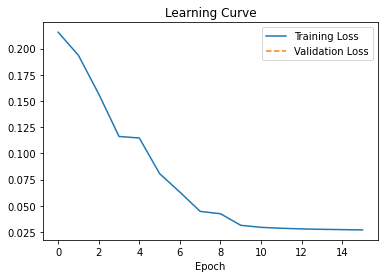

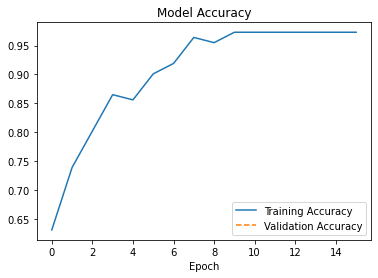

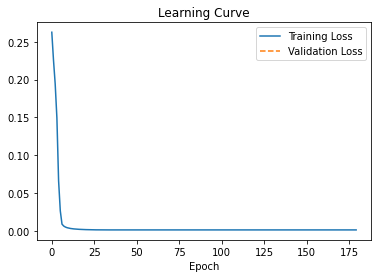

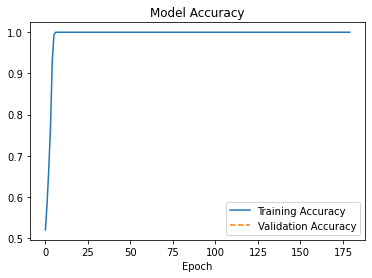

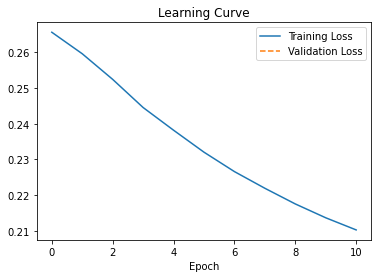

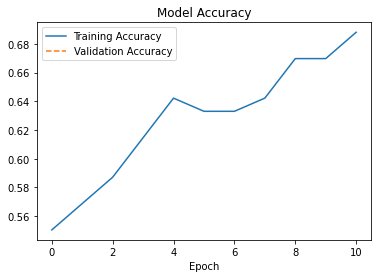

In [ ]:
import numpy as np

# Define the number of initializations
num_initializations = 5

# Iterate over each monk (dataset)
for dataset_i in range(datasets_number):
    print(f"\n### Monk {dataset_i + 1} ###")

    # Extract dataset for the current monk
    x = x_train[dataset_i].values
    y_fit = y_train[dataset_i].values
    X = x_test[dataset_i].values
    y = y_test[dataset_i].values

    tr_mse_values = []  # List to store MSE TR values for each initialization
    vl_mse_values = []  # List to store MSE VL values for each initialization
    vl_acc_values = []   # List to store Accuracies values for each initialization
    tr_acc_values = []   # List to store Accuracies values for each initialization


    # Inner loop for different initializations
    for _ in range(num_initializations):
        # Create a new model instance with the best hyperparameters for the current monk
        nn_instance = BinaryNN(params=nn[dataset_i].params, monk_i=dataset_i+1, trial=_+1)
        nn_instance.create_model(n_hidden_layers=n_hidden_layers_list[dataset_i])
        
        # Training the model
        nn_instance.fit(x_train=x,
               y_train=y_fit,           # Split 0.1 of validation   
                        )

        # Evaluating the model on TS
        nn_instance.evaluate(
                x_train=x,
                y_train=y_fit,
                x_val=X,            # "val" would be the test dataset in this case
                y_val=y,
                )
       
        # Access the training loss from the nn_instance and store it
        tr_mse_values.append(nn_instance.mean_tr_loss)
        vl_mse_values.append(nn_instance.mean_vl_loss)
        tr_acc_values.append(nn_instance.mean_tr_accuracy)
        vl_acc_values.append(nn_instance.mean_vl_accuracy)

        print("")
        nn_instance.print_training_info()
        print("")


    # Calculate and print mean, variance and standard deviation
    
    # Mean TR mse
    meantr_mse = np.mean(tr_mse_values)
    # Mean VL mse
    meanvl_mse = np.mean(vl_mse_values)
    
    # Mean TR accuracies
    meantr_acc = np.mean(tr_acc_values)
    # Mean VL accuracies
    meanvl_acc = np.mean(vl_acc_values)

    # Variance MSE VL
    variance_mse_vl = np.var(vl_mse_values)
    # Variance MSE TR
    variance_mse_tr = np.var(tr_mse_values)

    # Variance TR accuracies
    variancetr_acc = np.var(tr_acc_values)
    # Variance VL accuracies
    variancevl_acc = np.var(vl_acc_values)

    # Standard dev TR accuracies
    std_tr_acc = np.std(tr_acc_values)
    # Standard dev VL accuracies
    std_vl_acc = np.std(vl_acc_values)
    
    # Standard dev VL mse
    std_deviation_vl = np.std(vl_mse_values)
    # Standard dev TR mse
    std_deviation_tr = np.std(tr_mse_values)

    print(f'\nMean TR MSE: {meantr_mse}')
    print(f'\nMean VL MSE: {meanvl_mse}')
    print(f'\nMean TR Accuracy: {meantr_acc}')
    print(f'\nMean VL Accuracy: {meanvl_acc}')
    print(f'\nVariance TR MSE: {variance_mse_tr}')
    print(f'\nVariance VL MSE: {variance_mse_vl}')
    print(f'\nVariance TR Accuracy: {variancetr_acc}')
    print(f'\nVariance VL Accuracy: {variancevl_acc}')
    print(f'Standard Deviation TR MSE: {std_deviation_tr}')
    print(f'\nStandard Deviation VL MSE: {std_deviation_vl}')
    print(f'Standard Deviation TR Accuracy: {std_tr_acc}')
    print(f'Standard Deviation VL Accuracy: {std_vl_acc}')

    # Plot learning curves
    nn_instance.print_plot()


In [ ]:
# Recreating a monk1 model for debugging

import numpy as np

from keras import Model, Sequential
from keras.optimizers import SGD
from keras.layers import Dense
from keras.initializers import glorot_uniform
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from keras.optimizers.schedules import PolynomialDecay
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

#{'hidden_units': 4, 'patience': 30, 'learning_rate': 0.3, 'batch_size': 4, 'nesterov': 'T', 'epochs': 350, 'momentum': 0.6}

for i in range(1,5):

    # Extract dataset for the current monk
    x = x_train[0].values
    y_fit = y_train[0].values
    X = x_test[0].values
    y = y_test[0].values

    # Build the sequential model
    model = Sequential()

    # Input Layer
    model.add(Dense(units=17))


    model.add(Dense(
                    units=4,
                        activation="tanh",
                        kernel_initializer=glorot_uniform(seed=15),
                        use_bias=True
                    )
                )
    # Output Layer
    model.add(Dense(units=1, activation="sigmoid", use_bias=True))

    model.compile(
            loss='mean_squared_error',
            optimizer=SGD(
                learning_rate=0.3,
                momentum=0.6,
                nesterov=True
            ),
            metrics=["accuracy"]
            )

    model.fit(
                x=x,
                y=y_fit,
                epochs=350,
                batch_size=4,
                validation_split=0.1,
                callbacks=[EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)],
                verbose=1,
                shuffle=True
                )

    model.evaluate(X, y, verbose=1)



Epoch 1/350
28/28 [==============================] - 1s 11ms/step - loss: 0.2488 - accuracy: 0.5315 - val_loss: 0.3997 - val_accuracy: 0.1538
Epoch 2/350
28/28 [==============================] - 0s 5ms/step - loss: 0.1986 - accuracy: 0.6937 - val_loss: 0.4795 - val_accuracy: 0.2308
Epoch 3/350
28/28 [==============================] - 0s 4ms/step - loss: 0.1467 - accuracy: 0.8288 - val_loss: 0.5875 - val_accuracy: 0.2308
Epoch 4/350
28/28 [==============================] - 0s 4ms/step - loss: 0.1165 - accuracy: 0.8739 - val_loss: 0.6490 - val_accuracy: 0.2308
Epoch 5/350
28/28 [==============================] - 0s 5ms/step - loss: 0.0998 - accuracy: 0.9009 - val_loss: 0.6672 - val_accuracy: 0.2308
Epoch 6/350
28/28 [==============================] - 0s 4ms/step - loss: 0.0941 - accuracy: 0.9009 - val_loss: 0.6578 - val_accuracy: 0.2308
Epoch 7/350
28/28 [==============================] - 0s 4ms/step - loss: 0.0916 - accuracy: 0.9009 - val_loss: 0.6468 - val_accuracy: 0.2308
Epoch 8/350


# Different weights inizialitation using Kfold

In [ ]:
# Search of the best Hyperparameters to each Training set
for dataset_i in range(datasets_number):
    X = x_train[dataset_i].values
    y = y_train[dataset_i].values
    k = k_values[dataset_i]

    # K-fold Cross-validation
    kfold = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

    # Creation of the Neural Network object
    nn_i = BinaryNN(params=nn[dataset_i].params, monk_i=dataset_i+1, trial=+1)

    # For each K-fold returns the indexes of the data splitted in: <X_train,y_train> and <X_val,y_val>
    for train_index, val_index in kfold.split(X, y):
            x_kfold_train, x_kfold_val = X[train_index], X[val_index]
            y_kfold_train, y_kfold_val = y[train_index], y[val_index]

            # Building the model
            nn_i.create_model(n_hidden_layers=n_hidden_layers_list[dataset_i])

            # Training the model
            nn_i.fit(
                x_train=x_kfold_train,
                y_train=y_kfold_train,
                x_val=x_kfold_val,
                y_val=y_kfold_val
            )

            # Evaluating the model
            nn_i.evaluate(
                x_train=x_kfold_train,
                y_train=y_kfold_train,
                x_val=x_kfold_val,
                y_val=y_kfold_val
            )
            
            print()
            nn_i.print_training_info()
            print()
nn_i.print_plot()

 Monk:                              1
 Trial:                             1
 Hyperparameters:                   {'hidden_units': 3, 'patience': 15, 'learning_rate': 0.3, 'batch_size': 4, 'nesterov': 'T', 'epochs': 350, 'momentum': 0.6}
 Mean Training Loss:                0.00031955819576978683
 Mean Validation Loss:              0.0029789600521326065
 Mean Training Accuracy:            1.0
 Mean Validation Accuracy:          1.0
 Monk:                              1
 Trial:                             1
 Hyperparameters:                   {'hidden_units': 3, 'patience': 15, 'learning_rate': 0.3, 'batch_size': 4, 'nesterov': 'T', 'epochs': 350, 'momentum': 0.6}
 Mean Training Loss:                0.03981603076681495
 Mean Validation Loss:              0.0790370600298047
 Mean Training Accuracy:            0.9595959484577179
 Mean Validation Accuracy:          0.8799999952316284
 Monk:                              1
 Trial:                             1
 Hyperparameters:                 

IndexError: list index out of range

# Model Assessment & Evaluation 


### Testing of Monk 1 ###
 Monk:                              1
 Trial:                             2
 Hyperparameters:                   {'hidden_units': 4, 'patience': 15, 'learning_rate': 0.4, 'batch_size': 4, 'nesterov': 'T', 'epochs': 180, 'momentum': 0.6}
 Mean Training Loss:                7.594107682962203e-05
 Mean Validation Loss:              9.526879997186673e-05
 Mean Training Accuracy:            1.0
 Mean Validation Accuracy:          1.0
 Standard Deviation VL Accuracy:    0.0
 Variance VL Accuracy:              0.0
 Standard Deviation VL Loss:        9.651481313001692e-05
 Variance VL Loss:                  9.315109153522087e-09


### Testing of Monk 2 ###
 Monk:                              2
 Trial:                             1
 Hyperparameters:                   {'hidden_units': 3, 'patience': 15, 'factor_lr_dec': 0.5, 'step_decay': 500, 'learning_rate': 0.9, 'batch_size': 10, 'epochs': 180, 'momentum': 0.6, 'nesterov': 'T'}
 Mean Training Loss:                0.0

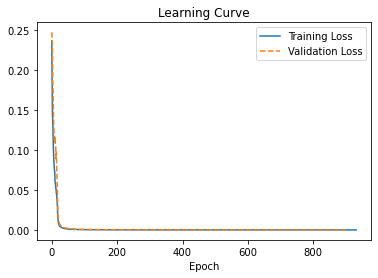

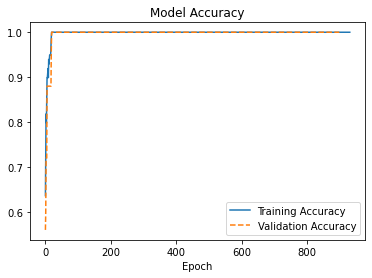

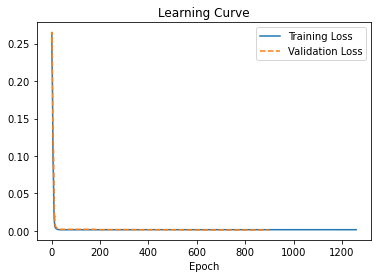

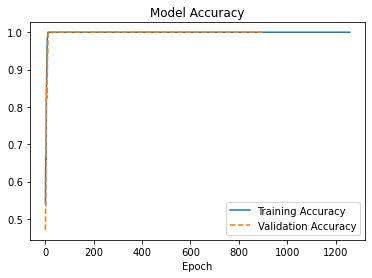

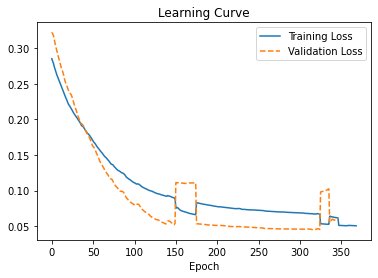

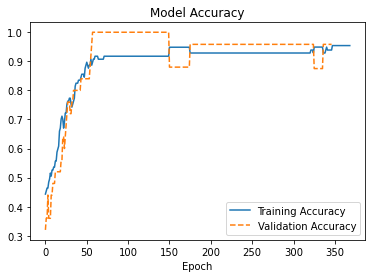

In [ ]:
# Iterations on each Dataset
for dataset_i in range(datasets_number):
    X = x_test[dataset_i].values
    y = y_test[dataset_i].values

    # Training the model
    nn[dataset_i].fit(
        x_train=x_train[dataset_i].values,
        y_train=y_train[dataset_i].values,
    )

    nn[dataset_i].evaluate(
        x_train=x_train[dataset_i].values,
        y_train=y_train[dataset_i].values,
        x_val = X,
        y_val =   y
    )
    print(f"\n### Testing of Monk {dataset_i+1} ###")
    nn[dataset_i].print_training_info()
    nn[dataset_i].print_plot()

 Monk:                         1
 Trial:                        2
 Hyperparameters:              {'hidden_units': 4, 'patience': 15, 'learning_rate': 0.4, 'batch_size': 4, 'nesterov': 'T', 'epochs': 180, 'momentum': 0.6}
 Mean Training Loss:           7.594107682962203e-05
 Mean Validation Loss:         9.526879997186673e-05
 Test Loss:                    3.242507591494359e-05
 Mean Training Accuracy:       1.0
 Mean Validation Accuracy:     1.0
 Test Accuracy:                1.0
 f1 score:                     1.0
 f2 score:                     1.0
 Precision score:              1.0
 Recall score:                 1.0

              Predicted_Class_0  Predicted_Class_1
Real_Class_0                216                  0
Real_Class_1                  0                216


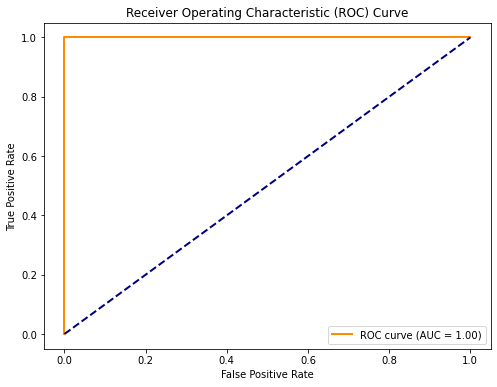

 Monk:                         2
 Trial:                        1
 Hyperparameters:              {'hidden_units': 3, 'patience': 15, 'factor_lr_dec': 0.5, 'step_decay': 500, 'learning_rate': 0.9, 'batch_size': 10, 'epochs': 180, 'momentum': 0.6, 'nesterov': 'T'}
 Mean Training Loss:           0.001488588498129199
 Mean Validation Loss:         0.0017858520926286776
 Test Loss:                    0.0032407883554697037
 Mean Training Accuracy:       1.0
 Mean Validation Accuracy:     1.0
 Test Accuracy:                1.0
 f1 score:                     1.0
 f2 score:                     1.0
 Precision score:              1.0
 Recall score:                 1.0

              Predicted_Class_0  Predicted_Class_1
Real_Class_0                290                  0
Real_Class_1                  0                142


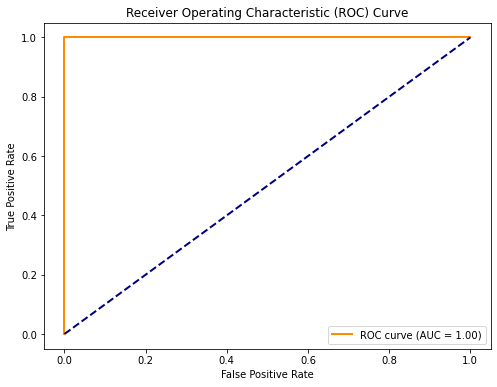

 Monk:                         3
 Trial:                        1
 Hyperparameters:              {'hidden_units': 3, 'patience': 10, 'learning_rate': 0.005, 'batch_size': 32, 'epochs': 150, 'momentum': 0.8, 'weight_decay': 0.001, 'nesterov': 'T'}
 Mean Training Loss:           0.06608508589367072
 Mean Validation Loss:         0.06918431259691715
 Test Loss:                    0.05293550342321396
 Mean Training Accuracy:       0.9371535778045654
 Mean Validation Accuracy:     0.9379475216070811
 Test Accuracy:                0.9560185074806213
 f1 score:                     0.9565217391304348
 f2 score:                     0.9322033898305083
 Precision score:              1.0
 Recall score:                 0.9166666666666666

              Predicted_Class_0  Predicted_Class_1
Real_Class_0                204                  0
Real_Class_1                 19                209


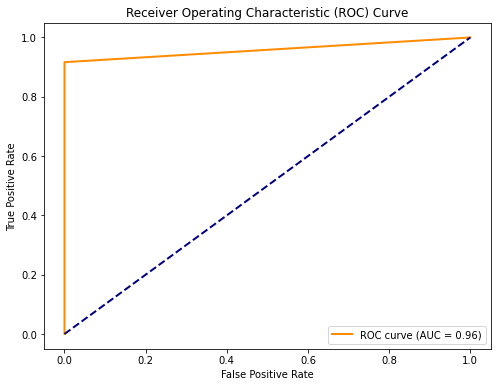

In [ ]:
# Final testing of the Models for each Test set
for dataset_i in range(datasets_number):
    X = x_test[dataset_i].values
    y = y_test[dataset_i].values

    # Evaluate the Model on TS set
    nn[dataset_i].test(
        x_test=X,
        y_test=y
    )

    # Computes the score of the Model
    nn[dataset_i].score(x_test=X, y_test=y)

    # Prints the results obtained
    print(nn[dataset_i])
    nn[dataset_i].print_confusion_matrix(y_test=y)
    nn[dataset_i].print_roc_curve(y_test=y)

 Monk:                         1
 Trial:                        1
 Hyperparameters:              {'hidden_units': 3, 'patience': 15, 'learning_rate': 0.3, 'batch_size': 4, 'nesterov': 'T', 'epochs': 350, 'momentum': 0.6}
 Mean Training Loss:           0.04034120522410376
 Mean Validation Loss:         0.051897669039317404
 Test Loss:                    0.0006457697018049657
 Mean Training Accuracy:       0.9515151619911194
 Mean Validation Accuracy:     0.9279999971389771
 Test Accuracy:                1.0
 f1 score:                     1.0
 f2 score:                     1.0
 Precision score:              1.0
 Recall score:                 1.0

              Predicted_Class_0  Predicted_Class_1
Real_Class_0                216                  0
Real_Class_1                  0                216


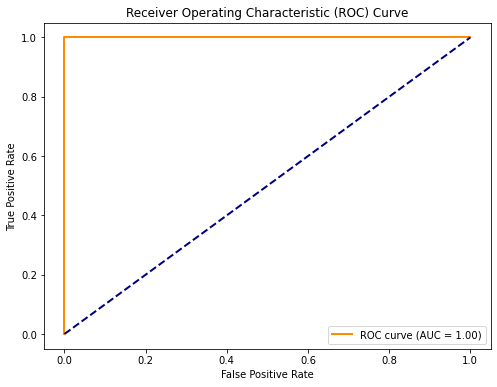

In [ ]:
X = x_test[0].values
y = y_test[0].values

    # Evaluate the Model on TS set
nn[0].test(
        x_test=X,
        y_test=y
    )

    # Computes the score of the Model
nn[0].score(x_test=X, y_test=y)

    # Prints the results obtained
print(nn[0])
nn[0].print_confusion_matrix(y_test=y)
nn[0].print_roc_curve(y_test=y)